In [1]:
import numpy as np
import random
import heapq
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
class DisasterZoneEnv:
    """
    A 2D grid environment for a drone exploring a disaster zone.

    Legend (internally stored as integers):
        0 -> Empty cell
        1 -> Obstacle
        2 -> Survivor
        3 -> Resource

    'D' in a scenario array indicates the drone's starting position (only in predefined scenarios).
    """

    def __init__(
        self,
        width=8,
        height=8,
        num_obstacles=5,
        num_survivors=3,
        num_resources=2,
        initial_energy=20,
        dynamic=False,
        predefined_grid=None,
        seed=None,                # Optional random seed
        recharge_amount=None      # If None => full recharge upon resource, else partial
    ):
        self.width = width
        self.height = height
        self.num_obstacles = num_obstacles
        self.num_survivors = num_survivors
        self.num_resources = num_resources
        self.initial_energy = initial_energy
        self.energy = initial_energy
        self.dynamic = dynamic
        self.seed = seed
        self.recharge_amount = recharge_amount
        self.dynamic_changes = 0

        if self.seed is not None:
            random.seed(self.seed)
            np.random.seed(self.seed)

        # If we have a predefined grid, load that; otherwise random layout
        if predefined_grid is not None:
            self.reset_with_scenario(predefined_grid)
        else:
            self.reset()

    def reset(self):
        """
        Create a random environment layout:
        - obstacles, survivors, resources randomly placed
        - random drone start
        """
        self.grid = np.zeros((self.height, self.width), dtype=int)

        # Place obstacles
        for _ in range(self.num_obstacles):
            x, y = self._get_random_empty_cell()
            self.grid[x, y] = 1

        # Place survivors
        for _ in range(self.num_survivors):
            x, y = self._get_random_empty_cell()
            self.grid[x, y] = 2

        # Place resources
        for _ in range(self.num_resources):
            x, y = self._get_random_empty_cell()
            self.grid[x, y] = 3

        # Random start for the drone
        self.drone_x, self.drone_y = self._get_random_empty_cell()
        self.energy = self.initial_energy

    def reset_with_scenario(self, scenario):
        """
        Load a predefined grid that may contain 'D' for the drone start.
        Convert it into an integer grid internally.
        """
        scenario = np.array(scenario, dtype=object)
        self.height, self.width = scenario.shape

        self.grid = np.zeros((self.height, self.width), dtype=int)

        drone_positions = []

        for i in range(self.height):
            for j in range(self.width):
                val = scenario[i, j]
                if val == 'D':
                    drone_positions.append((i, j))
                    self.grid[i, j] = 0  # treat 'D' cell as empty
                else:
                    self.grid[i, j] = int(val)

        if len(drone_positions) != 1:
            raise ValueError("Scenario must contain exactly one 'D' for the drone's start.")
        self.drone_x, self.drone_y = drone_positions[0]
        self.energy = self.initial_energy

    def _get_random_empty_cell(self):
        while True:
            x = random.randint(0, self.height - 1)
            y = random.randint(0, self.width - 1)
            if self.grid[x, y] == 0:
                return x, y

    def apply_dynamic_changes(self, step_count):
        """
        Example dynamic changes:
         - Add an obstacle every 5 steps
         - Move all survivors every 3 steps
        """
        if not self.dynamic:
            return

        # Add an obstacle every 5 steps
        if step_count > 0 and step_count % 5 == 0:
            x, y = self._get_random_empty_cell()
            self.grid[x, y] = 1
            self.dynamic_changes += 1

        # Move survivors every 3 steps
        if step_count > 0 and step_count % 3 == 0:
            survivor_positions = [
                (xx, yy) for xx in range(self.height)
                for yy in range(self.width)
                if self.grid[xx, yy] == 2
            ]
            for (sx, sy) in survivor_positions:
                self.grid[sx, sy] = 0
                nx, ny = self._get_random_empty_cell()
                self.grid[nx, ny] = 2

    def render(self):
        grid_copy = self.grid.astype(str)
        grid_copy[grid_copy == '0'] = '.'
        grid_copy[grid_copy == '1'] = '#'
        grid_copy[grid_copy == '2'] = 'S'
        grid_copy[grid_copy == '3'] = 'R'

        # Mark the drone location
        grid_copy[self.drone_x, self.drone_y] = 'D'

        for row in grid_copy:
            print(" ".join(row))
        print(f"Energy: {self.energy}\n")

In [24]:
class DijkstraAgent:
    """
    An agent using Dijkstra's algorithm for pathfinding.
    """

    def __init__(self, env):
        self.env = env
        self.steps_taken = 0
        self.survivors_rescued = 0
        self.resources_collected = 0

    def dijkstra_search(self, grid, start, goal):
        import heapq
        directions = [(-1,0), (1,0), (0,-1), (0,1)]
        pq = [(0, start)]  # (distance, position)
        distances = {start: 0}
        previous = {start: None}

        while pq:
            current_dist, current_pos = heapq.heappop(pq)
            if current_pos == goal:
                # Reconstruct path
                path = []
                while current_pos is not None:
                    path.append(current_pos)
                    current_pos = previous[current_pos]
                path.reverse()
                return path, current_dist

            for dx, dy in directions:
                nx = current_pos[0] + dx
                ny = current_pos[1] + dy
                if 0 <= nx < grid.shape[0] and 0 <= ny < grid.shape[1]:
                    # 1 => obstacle
                    if grid[nx, ny] != 1:
                        new_dist = current_dist + 1
                        if (nx, ny) not in distances or new_dist < distances[(nx, ny)]:
                            distances[(nx, ny)] = new_dist
                            previous[(nx, ny)] = current_pos
                            heapq.heappush(pq, (new_dist, (nx, ny)))

        return [], float('inf')

    def find_closest_target(self, target_type):
        """
        Find the path to the nearest cell with grid == target_type (2=Survivor or 3=Resource).
        """
        start = (self.env.drone_x, self.env.drone_y)
        targets = [
            (x, y) for x in range(self.env.height)
            for y in range(self.env.width)
            if self.env.grid[x, y] == target_type
        ]
        if not targets:
            return None, None, float('inf')

        best_path = None
        best_target = None
        best_dist = float('inf')

        for t in targets:
            path, dist = self.dijkstra_search(self.env.grid, start, t)
            if dist < best_dist:
                best_dist = dist
                best_path = path
                best_target = t

        return best_path, best_target, best_dist

    def execute(self):
        step_count = 0
        while self.env.energy > 0:
            # 1) look for survivors
            path, target_pos, _ = self.find_closest_target(2)
            if not path:
                # 2) then look for resources
                path, target_pos, _ = self.find_closest_target(3)

            if not path:
                print("No reachable targets. Stopping.")
                break

            # Move step by step
            for cell in path[1:]:
                self.env.drone_x, self.env.drone_y = cell
                self.steps_taken += 1
                step_count += 1

                # if environment is dynamic
                if self.env.dynamic:
                    self.env.apply_dynamic_changes(step_count)

                self.env.energy -= 1
                if self.env.energy <= 0:
                    break

            # If we actually reached a target
            if target_pos:
                cell_val = self.env.grid[target_pos[0], target_pos[1]]
                if cell_val == 2:
                    self.survivors_rescued += 1
                elif cell_val == 3:
                    self.resources_collected += 1
                # Mark empty
                self.env.grid[target_pos[0], target_pos[1]] = 0

In [25]:
class AStarDrone:
    def __init__(self, env, initial_position=None): #CHANGE
        self.env = env
        # Use the provided initial position or fall back to the environment's drone position
        self.position = initial_position if initial_position else (self.env.drone_x, self.env.drone_y)
        self.start_position = self.position
        self.visited = set()
        self.path = []
        self.energy = env.initial_energy
        self.steps_taken = 0
        self.survivors_rescued = 0
        self.resources_collected = 0
        self.energy_used = 0

    def execute(self):
        while True:
            # Stop if energy is insufficient for further action
            if self.energy <= 0:
                print("Out of energy! Ending mission.")
                return False

            # Find the nearest target (survivor or recharge point)
            target = self.find_nearest_target()
            if not target:
                print("No reachable targets left. Ending mission.")
                return False

            # Use A* to move towards the target
            next_move = self.a_star_search(self.position, target)
            if next_move:
                action = self.calculate_action(self.position, next_move)
                self.position = next_move
                self.visited.add(self.position)
                self.path.append(self.position)

                # Deduct energy for the move
                self.energy -= 1
                self.energy_used += 1
                self.steps_taken += 1

                # Apply dynamic changes to the environment
                self.env.apply_dynamic_changes(self.steps_taken)

                # Check and handle grid value
                current_cell = self.env.grid[self.position[0]][self.position[1]]
                if current_cell == 2:  # Rescue survivor
                    self.survivors_rescued += 1
                    self.env.grid[self.position[0]][self.position[1]] = 0
                    print(f"Survivor rescued at {self.position}")
                elif current_cell == 3:  # Collect resource (recharge)
                    self.resources_collected += 1
                    self.env.grid[self.position[0]][self.position[1]] = 0
                    self.energy = min(self.energy + 5, self.env.initial_energy)
                    print(f"Recharged at {self.position}. Current energy: {self.energy}")
            else:
                print("Unable to proceed further. Ending mission.")
                return False

    def find_nearest_target(self):
        """Find the nearest survivor (2) or recharge point (3)."""
        targets = []
        for x in range(self.env.height):
            for y in range(self.env.width):
                if self.env.grid[x][y] in [2, 3]:
                    targets.append((x, y))
        
        if not targets:
            return None  # No targets left

        # Find the closest target based on Manhattan distance
        return min(targets, key=lambda t: self.heuristic(self.position, t))

    def a_star_search(self, start, goal):
        """Perform A* search to find the best path from start to goal."""
        open_list = []
        heapq.heappush(open_list, (0, start))
        came_from = {}
        g_score = {start: 0}
        f_score = {start: self.heuristic(start, goal)}
        visited = set()

        while open_list:
            _, current = heapq.heappop(open_list)
            if current == goal:
                return self.reconstruct_path(came_from, current)
            
            visited.add(current)

            for neighbor in self.get_neighbors(current):
                if neighbor in visited or self.env.grid[neighbor[0]][neighbor[1]] == 1:
                    continue

                tentative_g_score = g_score[current] + 1
                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + self.heuristic(neighbor, goal)
                    heapq.heappush(open_list, (f_score[neighbor], neighbor))
        
        return None

    def get_neighbors(self, position):
        """Get valid neighboring cells."""
        x, y = position
        neighbors = []
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < self.env.height and 0 <= ny < self.env.width:
                if self.env.grid[nx][ny] != 1:
                    neighbors.append((nx, ny))
        return neighbors

    def heuristic(self, position, goal):
        """Heuristic prioritizing Manhattan distance with survivor proximity."""
        dist = abs(position[0] - goal[0]) + abs(position[1] - goal[1])
        # Favor survivors slightly over recharge points
        grid_value = self.env.grid[goal[0]][goal[1]]
        return dist - (5 if grid_value == 2 else 0)

    def reconstruct_path(self, came_from, current):
        """Reconstruct the path to the goal."""
        path = []
        while current in came_from:
            path.append(current)
            current = came_from[current]
        path.reverse()
        return path[0] if path else None

    def calculate_action(self, current, next_position):
        """Determine the action direction."""
        dx, dy = next_position[0] - current[0], next_position[1] - current[1]
        if dx == -1: return 'UP'
        if dx == 1: return 'DOWN'
        if dy == -1: return 'LEFT'
        if dy == 1: return 'RIGHT'
        raise ValueError("Invalid move.")   

In [26]:
# Cell 4: Scenarios Dictionary

SCENARIOS_DICT = {
    "Scenario_1": {
        "name": "Simple Layout",
        "grid": np.array([
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0, 0],
            [0, 2, 0, 1, 0, 0, 3, 0],
            [0, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 2, 0, 0],
            [3, 0, 0, 0, 0, 0, 0, 'D']
        ], dtype=object),
        "dynamic": False,
        "description": "Minimal obstacles, static environment"
    },
    "Scenario_2": {
        "name": "Obstacle Maze",
        "grid": np.array([
            [0, 1, 1, 1, 0, 0, 0, 0],
            [0, 1, 2, 1, 0, 1, 1, 0],
            [0, 1, 0, 1, 0, 1, 0, 0],
            [0, 0, 0, 1, 0, 1, 0, 0],
            [0, 1, 0, 1, 0, 1, 0, 3],
            [0, 1, 0, 0, 0, 1, 0, 0],
            [0, 0, 0, 1, 0, 0, 2, 0],
            ['D', 1, 0, 0, 0, 0, 0, 0]
        ], dtype=object),
        "dynamic": False,
        "description": "A more complex layout"
    },
    "Scenario_3": {
        "name": "Dynamic Mixed Layout",
        "grid": np.array([
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 2, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 3, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 2, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 3, 0, 0, 0, 0],
            ['D', 0, 0, 0, 0, 0, 0, 0]
        ], dtype=object),
        "dynamic": True,
        "description": "Dynamic environment with obstacles and survivors moving"
    },

    # Larger 12x12 static
    "Scenario_4": {
        "name": "Large 12x12 Static",
        "grid": np.array([
            [0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0],
            [0, 2, 1, 1, 0, 0, 1, 0, 0, 3, 0, 0],
            [1, 1, 1, 0, 0, 0, 0, 1, 2, 0, 0, 1],
            [0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0],
            [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 2, 1, 0, 3, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
            [3, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 1, 3, 0, 2, 0, 0],
            ['D', 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
        ], dtype=object),
        "dynamic": False,
        "description": "A bigger static scenario with more obstacles, survivors, resources"
    },

    # Larger 12x12 dynamic
    "Scenario_5": {
        "name": "Large 12x12 Dynamic",
        "grid": np.array([
            [0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0],
            [0, 2, 1, 1, 0, 0, 1, 0, 0, 3, 0, 0],
            [1, 1, 1, 0, 0, 0, 0, 1, 2, 0, 0, 1],
            [0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0],
            [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 2, 1, 0, 3, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
            [3, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 1, 3, 0, 2, 0, 0],
            ['D', 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
        ], dtype=object),
        "dynamic": True,
        "description": "A bigger dynamic scenario for differences between A* and Dijkstra"
    },
}

In [27]:
# Cell 5: Tester

class Tester:
    """
    Runs multiple agents on multiple scenarios, collects metrics into a results table.
    """

    def __init__(self, agent_classes, scenarios_dict, env_params=None):
        self.agent_classes = agent_classes
        self.scenarios_dict = scenarios_dict
        self.env_params = env_params if env_params else {}
        self.results = []

    def run_all_scenarios(self):
        for scenario_id, scenario_info in self.scenarios_dict.items():
            scenario_grid = scenario_info["grid"]
            scenario_name = scenario_info.get("name", scenario_id)
            scenario_dynamic = scenario_info.get("dynamic", False)
            scenario_desc = scenario_info.get("description", "")

            # Merge scenario-level dynamic with global env_params
            # i.e., if scenario_dynamic is True, we override env_params' dynamic
            param_dynamic = scenario_dynamic or self.env_params.get("dynamic", False)
            param_initial_energy = scenario_info.get("initial_energy", self.env_params.get("initial_energy", 20))

            # Optionally override other parameters if needed (like num_obstacles, seed, etc.)
            # but for now we just keep global env_params for these

            for agent_class in self.agent_classes:
                # Create environment
                env = DisasterZoneEnv(
                    width=self.env_params.get("width", 8),
                    height=self.env_params.get("height", 8),
                    num_obstacles=self.env_params.get("num_obstacles", 5),
                    num_survivors=self.env_params.get("num_survivors", 3),
                    num_resources=self.env_params.get("num_resources", 2),
                    initial_energy=param_initial_energy,
                    dynamic=param_dynamic,
                    predefined_grid=scenario_grid,
                    seed=self.env_params.get("seed", None),
                    recharge_amount=self.env_params.get("recharge_amount", None)
                )

                # Instantiate agent
                agent = agent_class(env)

                start_time = time.time()
                agent.execute()   
                end_time = time.time()
                comp_time = end_time - start_time

                # Collect results
                self.results.append({
                    "Scenario ID": scenario_id,
                    "Scenario Name": scenario_name,
                    "Description": scenario_desc,
                    "Is Dynamic": param_dynamic,
                    "Agent Name": agent_class.__name__,
                    "Steps Taken": getattr(agent, "steps_taken", None),
                    "Survivors Rescued": getattr(agent, "survivors_rescued", None),
                    "Resources Collected": getattr(agent, "resources_collected", None),
                    "Energy Used": param_initial_energy - env.energy,
                    "Computation Time (s)": comp_time
                })

    def get_results_df(self):
        return pd.DataFrame(self.results)

    def save_results(self, filename="results.csv"):
        df = pd.DataFrame(self.results)
        df.to_csv(filename, index=False)
        print(f"Results saved to {filename}")

In [28]:
# Cell 6: Example Execution

# We'll compare Dijkstra and AStar on all scenarios
agent_list = [DijkstraAgent, AStarDrone]

# We'll test them with these default environment params
env_params = {
    "width": 12,           # We'll force a 12x12 grid for all, but scenario_1,2,3 are actually 8x8
                           # The scenario's shape actually overrides this for predefined grids, but that's okay.
    "height": 12,
    "num_obstacles": 5,    # For random scenario usage only
    "num_survivors": 3,
    "num_resources": 2,
    "initial_energy": 25,  # Slightly higher energy to handle bigger grids
    "dynamic": False,      # We'll rely on scenario dict for dynamic= True or False
    "seed": 42             # Reproducible
}

# Instantiate the tester
tester = Tester(agent_classes=agent_list, scenarios_dict=SCENARIOS_DICT, env_params=env_params)

# Run all scenarios
tester.run_all_scenarios()

# Get results as DataFrame
df_results = tester.get_results_df()
print(df_results)

# Optionally save
tester.save_results("results_comparison.csv")

Survivor rescued at (6, 5)
Survivor rescued at (2, 1)
Recharged at (2, 6). Current energy: 10
Out of energy! Ending mission.
No reachable targets. Stopping.
Survivor rescued at (1, 2)
Survivor rescued at (6, 6)
Recharged at (4, 7). Current energy: 10
No reachable targets left. Ending mission.
Survivor rescued at (1, 1)
Survivor rescued at (0, 3)
Recharged at (2, 4). Current energy: 13
Recharged at (6, 3). Current energy: 13
No reachable targets left. Ending mission.
Recharged at (7, 0). Current energy: 25
Survivor rescued at (5, 4)
Survivor rescued at (7, 8)
Survivor rescued at (10, 9)
Recharged at (10, 7). Current energy: 12
Recharged at (8, 6). Current energy: 14
Survivor rescued at (2, 8)
Recharged at (1, 9). Current energy: 7
Recharged at (0, 5). Current energy: 7
Survivor rescued at (1, 1)
Out of energy! Ending mission.
Survivor rescued at (8, 1)
Survivor rescued at (9, 0)
Recharged at (7, 0). Current energy: 22
Survivor rescued at (6, 1)
Survivor rescued at (10, 4)
Out of energy!

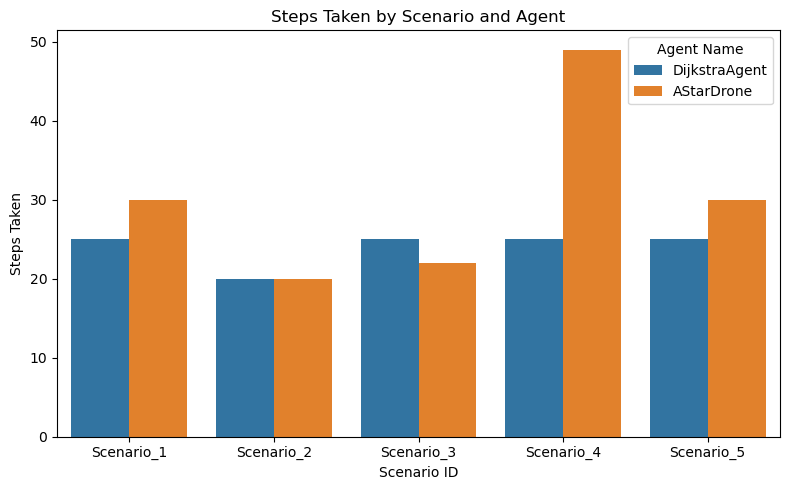

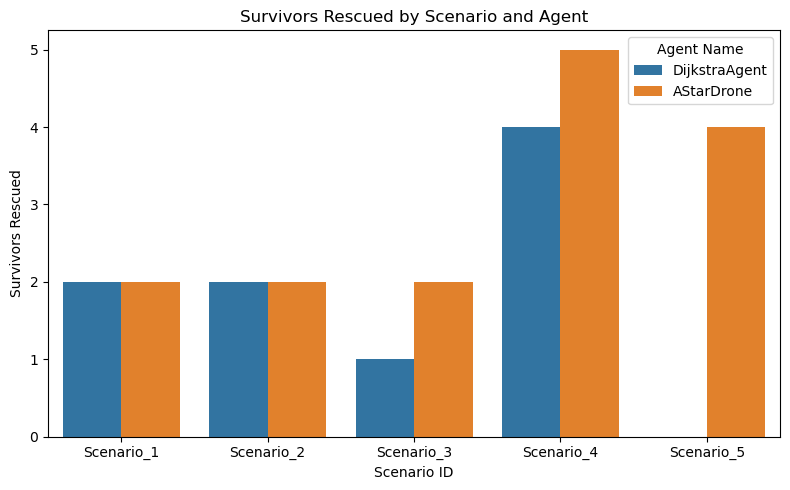

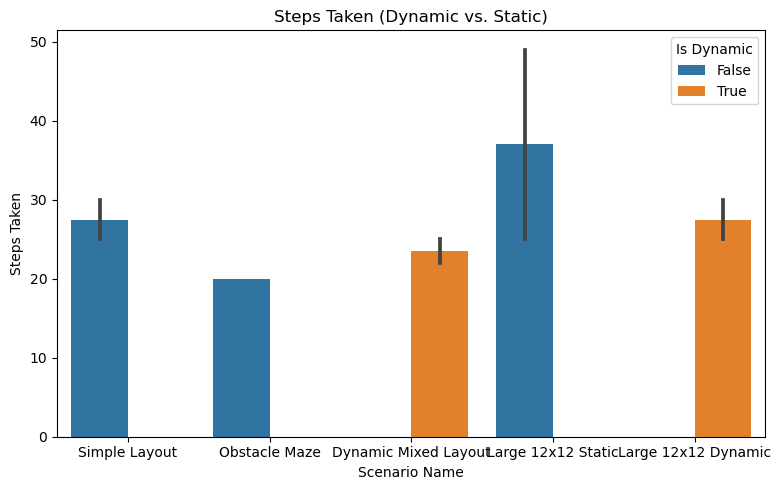

In [29]:
df = df_results  # for convenience

# 1) Basic bar plot of "Steps Taken"
plt.figure(figsize=(8,5))
sns.barplot(data=df, x="Scenario ID", y="Steps Taken", hue="Agent Name")
plt.title("Steps Taken by Scenario and Agent")
plt.tight_layout()
plt.show()

# 2) Survivors Rescued
plt.figure(figsize=(8,5))
sns.barplot(data=df, x="Scenario ID", y="Survivors Rescued", hue="Agent Name")
plt.title("Survivors Rescued by Scenario and Agent")
plt.tight_layout()
plt.show()

# 3) If you want to see how dynamic vs static differ, you can do e.g.:
plt.figure(figsize=(8,5))
sns.barplot(data=df, x="Scenario Name", y="Steps Taken", hue="Is Dynamic")
plt.title("Steps Taken (Dynamic vs. Static)")
plt.tight_layout()
plt.show()